In [13]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, batch_data_by_country

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [14]:
TRAIN_PROPORTION = 0.9
PERIOD = 4  # Year to year prediction
device = get_device()

In [15]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [16]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  #noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

x_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
x_valid_t = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_hf_t = torch.tensor(x_hf, dtype=torch.float32).to(device)

print(all_gts['country'].unique())

X_train shape : (445, 180)
X_valid shape : (53, 180)
y_train shape : (445,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Smoothing model

In [17]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'y_true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

Using cuda device


100%|██████████| 100/100 [00:00<00:00, 185.18it/s]


Final training loss: 0.014304396696388721
Final validation loss: 0.4903640151023865
Final validation R^2: 0.34815799759278176


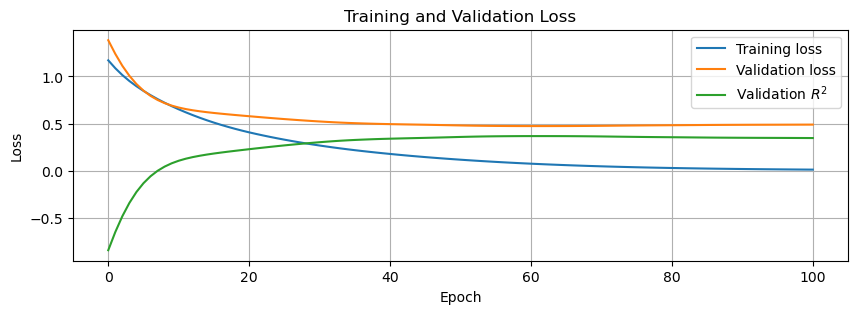

Basic R2 score: 0.34815799759278176


In [18]:
basic_model, basic_training_loss, basic_validation_loss, basic_validation_r_squared, basic_global_mse_losses = train_nn(X_train, 
                                                                        y_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        seed=SEED)

# Get the predictions
basic_y_pred_hf = basic_model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()
basic_y_pred_lf = basic_model(torch.cat((x_train_t, x_valid_t), 0)).clone().detach().cpu().numpy().squeeze()
basic_r2_score = results.r2_score(y_valid, basic_model(x_valid_t).clone().detach().cpu().numpy().squeeze())

print(f"Basic R2 score: {basic_r2_score}")

### Case Study: Fourrier Transform Smoothing

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Function to perform wavelet decomposition and visualization
def visualize_wavelet_transform(series, wavelet='db1', levels=None):
    """
    Visualize the wavelet transform process including the original signal,
    approximation coefficients, detail coefficients, and their reconstructions.

    Parameters:
    series (array-like): The input time series.
    wavelet (str): The type of wavelet to use (default: 'db1').
    levels (int): Number of decomposition levels (default: max possible levels).
    """
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(series, wavelet, level=levels)
    
    # Extract approximation and detail coefficients
    approximation = coeffs[0]
    details = coeffs[1:]

    # Plot the original signal
    plt.figure(figsize=(12, 8))
    plt.subplot(len(details) + 2, 1, 1)
    plt.plot(series, label='Original Signal')
    plt.title('Original Signal')
    plt.legend()

    # Plot approximation coefficients
    plt.subplot(len(details) + 2, 1, 2)
    plt.plot(approximation, label='Approximation Coefficients')
    plt.title('Approximation Coefficients (Level 1)')
    plt.legend()

    # Plot detail coefficients for each level
    for i, detail in enumerate(details, start=1):
        plt.subplot(len(details) + 2, 1, i + 2)
        plt.plot(detail, label=f'Detail Coefficients (Level {i})')
        plt.title(f'Detail Coefficients (Level {i})')
        plt.legend()

    plt.tight_layout()
    plt.show()


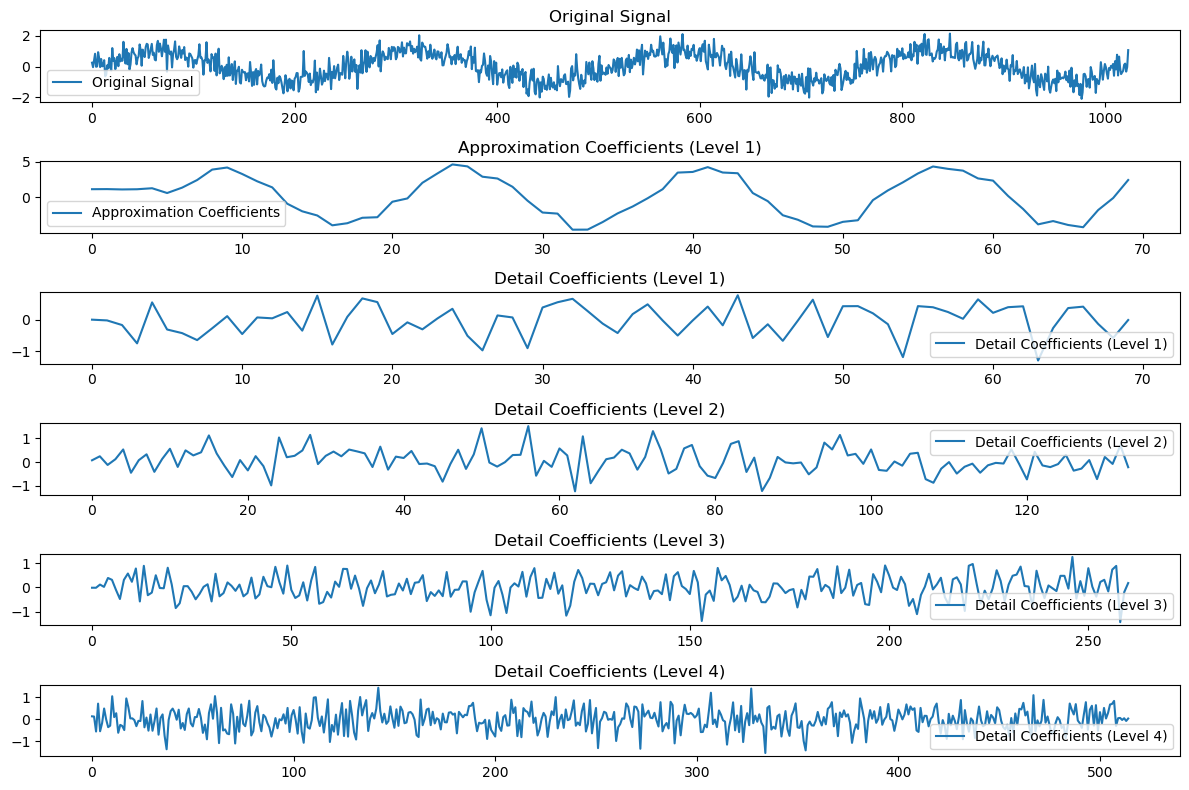

In [20]:
# Generate a sample signal (sine wave + noise)
x = np.linspace(0, 1, 1024)
series = np.sin(8 * np.pi * x) + 0.5 * np.random.randn(1024)

# Visualize wavelet transform
visualize_wavelet_transform(series, wavelet='db4', levels=4)

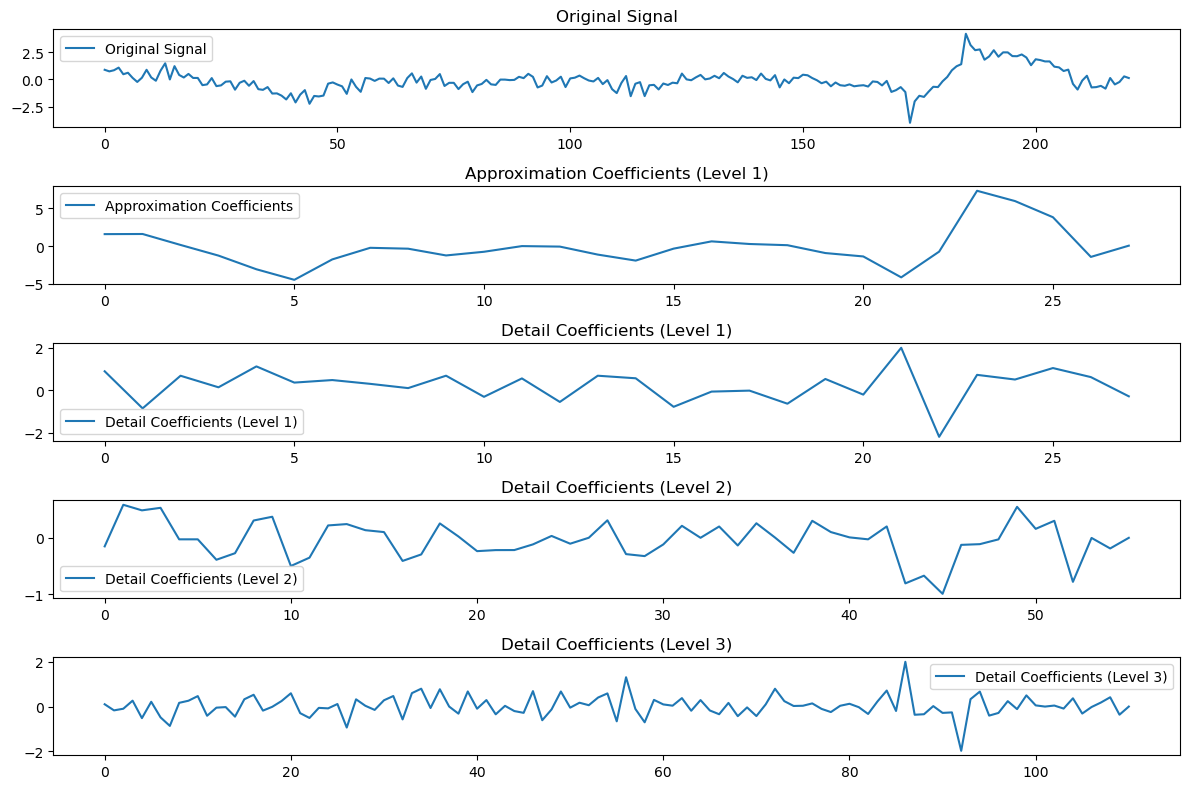

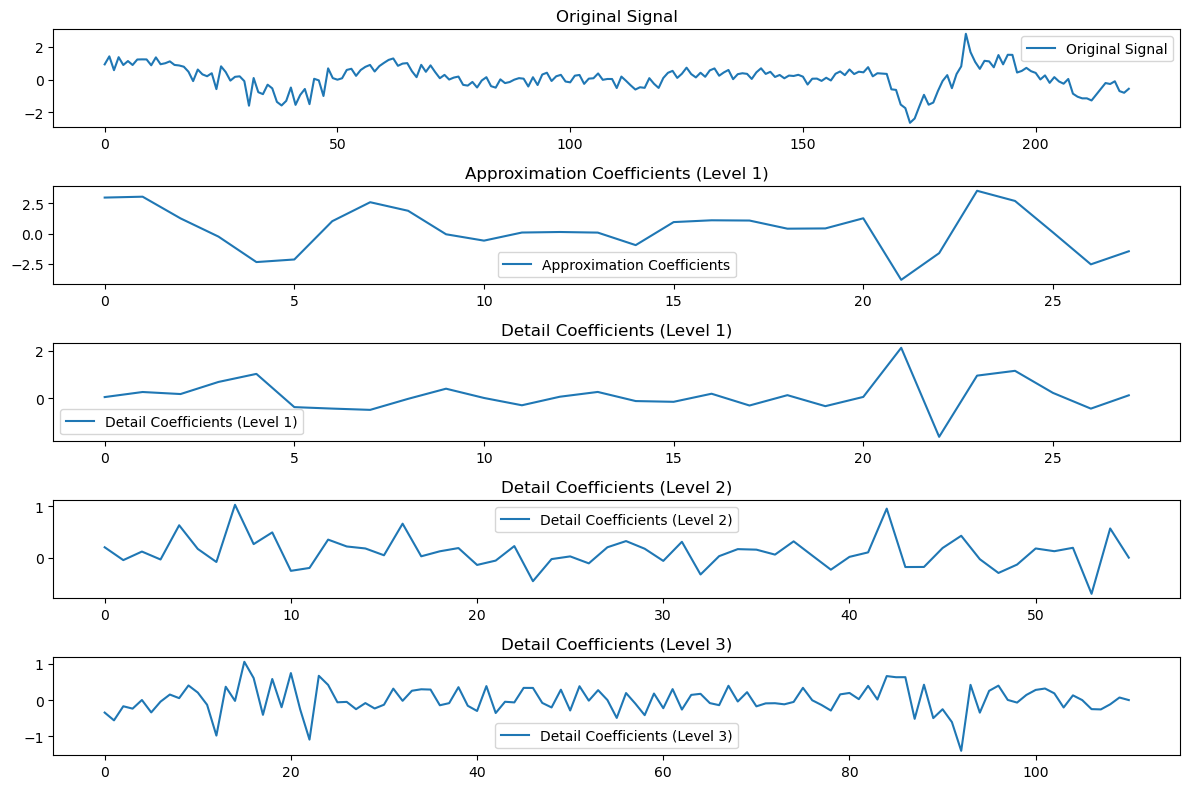

In [23]:
df_preds_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [basic_y_pred_hf[i] for i in range(len(basic_y_pred_hf))] 
})


# Per country
for country in df_preds_hf['country'].unique()[:2]:
    country_data = df_preds_hf[df_preds_hf['country'] == country]
    visualize_wavelet_transform(country_data['data'].values, levels=3)